In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from tqdm import tqdm

In [38]:
# Define data directories
train_dir = r'F:\NOTES\Season 3.2\DIP\data\students_data\train\images'
val_dir = r'F:\NOTES\Season 3.2\DIP\data\students_data\test\images'

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=1),
    'val': DataLoader(image_datasets['val'], batch_size=4, shuffle=False, num_workers=1),
}


print(f'length of training images per batch: {len(dataloaders["train"])} ')
print(f'length of validation images per batch: {len(dataloaders["val"])} ')


length of training images per batch: 178 
length of validation images per batch: 45 


In [14]:

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ResNet model and modify the final layer for 3 classes guns,knives & safe
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
summary(model, (3, 256, 256))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [30]:
# Train and evaluate the model
def train_model(model, criterion, optimizer, num_epochs):
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],desc=f'{phase} phase'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Evaluate the model and calculate metrics
def evaluate_model(model, dataloaders, criterion):
    
    model.eval()
    y_true = []
    y_pred = []
    filenames = []
    #iou_scores = []
    count = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['val'],desc="testing"):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            filenames.extend([f[0] for f in dataloaders['val'].dataset.imgs])

            count += 1
            
            # Calculate IoU score for each image
            """ for i in range(len(labels)):
                iou = jaccard_score(labels.cpu().numpy()[i:i+1], preds.cpu().numpy()[i:i+1], average='macro')
                iou_scores.append(iou) """

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f'Validation Accuracy: {acc:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Create CSV file
    results = []
    for i in range(len(filenames)):
        results.append({
            'image_name': os.path.basename(filenames[i]),  # Get the image file name
            'actual_class': class_names[y_true[i]],
            'predicted_class': class_names[y_pred[i]],
            'prediction': 'True' if class_names[y_pred[i]] == class_names[y_true[i]] else 'False'
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv('predictions.csv', index=False)

    return acc, cm, results_df


Epoch 0/9
----------


train phase: 100%|██████████| 178/178 [06:37<00:00,  2.23s/it]


train Loss: 0.5564 Acc: 0.7792


val phase: 100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


val Loss: 1.3330 Acc: 0.6180

Epoch 1/9
----------


train phase: 100%|██████████| 178/178 [08:06<00:00,  2.74s/it]


train Loss: 0.5133 Acc: 0.7890


val phase: 100%|██████████| 45/45 [00:35<00:00,  1.27it/s]


val Loss: 1.2673 Acc: 0.6236

Epoch 2/9
----------


train phase: 100%|██████████| 178/178 [05:36<00:00,  1.89s/it]


train Loss: 0.4246 Acc: 0.8340


val phase: 100%|██████████| 45/45 [00:37<00:00,  1.19it/s]


val Loss: 1.1465 Acc: 0.7022

Epoch 3/9
----------


train phase: 100%|██████████| 178/178 [05:45<00:00,  1.94s/it]


train Loss: 0.4123 Acc: 0.8312


val phase: 100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


val Loss: 2.2181 Acc: 0.5169

Epoch 4/9
----------


train phase: 100%|██████████| 178/178 [10:18<00:00,  3.48s/it]


train Loss: 0.3659 Acc: 0.8509


val phase: 100%|██████████| 45/45 [00:49<00:00,  1.10s/it]


val Loss: 2.7143 Acc: 0.6124

Epoch 5/9
----------


train phase: 100%|██████████| 178/178 [08:42<00:00,  2.93s/it]


train Loss: 0.3879 Acc: 0.8565


val phase: 100%|██████████| 45/45 [00:37<00:00,  1.19it/s]


val Loss: 1.2588 Acc: 0.6461

Epoch 6/9
----------


train phase: 100%|██████████| 178/178 [08:51<00:00,  2.98s/it]


train Loss: 0.3221 Acc: 0.8748


val phase: 100%|██████████| 45/45 [01:29<00:00,  2.00s/it]


val Loss: 1.7953 Acc: 0.6124

Epoch 7/9
----------


train phase: 100%|██████████| 178/178 [08:21<00:00,  2.82s/it]


train Loss: 0.3107 Acc: 0.8692


val phase: 100%|██████████| 45/45 [00:50<00:00,  1.12s/it]


val Loss: 1.5896 Acc: 0.6236

Epoch 8/9
----------


train phase: 100%|██████████| 178/178 [07:19<00:00,  2.47s/it]


train Loss: 0.3460 Acc: 0.8565


val phase: 100%|██████████| 45/45 [00:49<00:00,  1.09s/it]


val Loss: 2.0016 Acc: 0.6011

Epoch 9/9
----------


train phase: 100%|██████████| 178/178 [07:43<00:00,  2.60s/it]


train Loss: 0.2977 Acc: 0.8678


val phase: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


val Loss: 1.2280 Acc: 0.6461

Best val Acc: 0.702247
Validation Accuracy: 0.6461
Confusion Matrix:
[[86  7  0]
 [ 8 22  0]
 [32 16  7]]


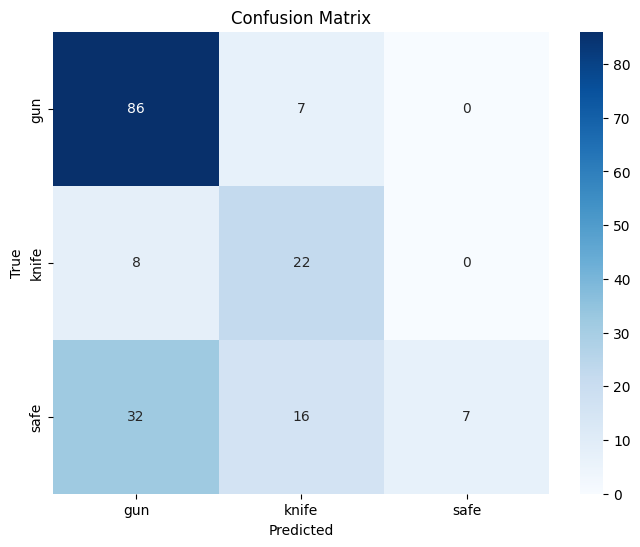

Evaluation Complete.
Accuracy: 0.6461
Confusion Matrix:
[[86  7  0]
 [ 8 22  0]
 [32 16  7]]
Results saved to predictions.csv


In [18]:
# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10)

# Save the model
torch.save(model.state_dict(), r'F:\NOTES\Season 3.2\DIP\Project\models\classifier.pth')

# Evaluate the model
accuracy, confusion_matrix, results_df = evaluate_model(model, dataloaders, criterion)
print('Evaluation Complete.')
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(confusion_matrix)
print('Results saved to predictions.csv')
